# To note:
### The code file loads a function 'assignment' which is the task given in tutorial 3 to implement the MSA assignment function that can calculate user equilibrium assignment. Therefore these codes can not be excuted without the said MSA assignment function and students can instead use 'network_performance_analysis_AON.ipynb' file to be able to run a copy of the below code with simple all-or-nothing assignment. 

In [1]:
# libraries
import pandas as pd
import os
import networkx as nx
import math
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

# local functions
from utils import import_matrix
# from assign import AONloading, Assignment # this module contains the AONloading function from tutorial 3 and the Assignment function you wrote for tutorial 3 homework

pd.options.mode.chained_assignment = None 

# Manila case study

## Loading model data

In [2]:
root    = './'
city    = 'Dresden'

In [3]:
#-------------------- Network --------------------

# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces

netfile = os.path.join(root, city, 'net.csv')
network = pd.read_csv(netfile)#, header=7)

trimmed= [s.strip().lower() for s in network.columns]
network.columns = trimmed
    

In [4]:
#-------------------- Network attributes --------------------

linkindexordering = list(zip(network['from'], network['to']))
edge_attr = {}
mlt = False
for row in network.itertuples():
    edge_attr[(row[1], row[2])] = {'capacity':row[3], 'length':row[4], 'FFT':row[5], 'alpha':row[6],
                                    'beta':row[7], 'type':row[10], 'flow':0, 'cost':row[5], 'Oflow':None}
    
edge = [(row[1], row[2]) for row in network.itertuples()]

In [5]:
#-------------------- Graph --------------------

NetGraph = nx.DiGraph()
NetGraph.add_edges_from(edge)
nx.set_edge_attributes(NetGraph, edge_attr)

In [6]:
demandfile = os.path.join(root, city, 'ODDemand.csv')
odDemands = pd.read_csv(demandfile, header=0)
ODdemand = {(int(row['Origin']), int(row['Destination'])):int(row['Demand']) for index, row in odDemands.iterrows()}

In [7]:
#-------------------- Zone centroids --------------------

centroidspath = os.path.join(root, city, 'centroid.csv')
centroids = pd.read_csv(centroidspath, header=0)

if 'fishnetID' in centroids.columns:
    centroids.rename(columns={'fishnetID': 'ZoneID'}, inplace=True)

zone2cent = {zone: [row['osmid'] for index, row in centroids[centroids['ZoneID'] == zone].iterrows()] for zone in centroids['ZoneID']}


## Assignment

In [8]:
def AONloading(graph, zone2centroid, demand, compute_sptt=False):
    """
    All-or-Nothing (AON) traffic assignment with shortest path travel time (SPTT) computation.

    Parameters:
        graph (nx.DiGraph): A directed graph representing the road network, with 'cost' as the edge weight.
        zone2centroid (dict): Maps zones to lists of centroid nodes within each zone.
        demand (dict): OD demand values as a dictionary {(origin_zone, destination_zone): demand}.
        compute_sptt (bool): Flag to compute SPTT and EODTT for OD pairs.

    Returns:
        tuple: 
            - SPTT (float): Total shortest path travel time across all OD pairs.
            - x_bar (dict): Edge flow for each edge in the graph.
            - spedges (dict): Shortest paths for each OD pair (optional, if `compute_sptt` is True).
            - EODTT (dict): End-to-end travel times for OD pairs (optional, if `compute_sptt` is True).
    """
    # Initialize outputs
    x_bar = {edge: 0 for edge in graph.edges()}  # Edge flows
    spedges = {}  # Shortest paths for OD pairs
    EODTT = {}  # End-to-end travel times
    SPTT = 0  # Shortest path travel time
    
    # Iterate through origin zones and their centroid nodes
    for origin_zone, origin_nodes in zone2centroid.items():
        # Compute shortest paths from all centroids in the origin zone
        dijkstra_results = [
            nx.single_source_dijkstra(graph, origin_node, weight="cost") for origin_node in origin_nodes
        ]
        
        # Iterate through destination zones and their centroid nodes
        for destination_zone, destination_nodes in zone2centroid.items():
            if origin_zone == destination_zone:
                continue  # Skip intra-zone flows
            
            # Get the demand for the OD pair
            od_demand = demand.get((origin_zone, destination_zone), 0)
            if od_demand <= 0:
                continue  # Skip if no demand
            
            # Find the shortest path among all centroid-to-centroid paths
            shortest_paths = [
                (dijkstra_results[i][0][dest_node], dijkstra_results[i], dest_node)
                for i in range(len(dijkstra_results))
                for dest_node in destination_nodes
                if dest_node in dijkstra_results[i][0]
            ]
            
            if not shortest_paths:
                continue  # Skip if no valid path exists
            
            # Select the shortest path
            shortest_paths.sort(key=lambda x: x[0])  # Sort by travel time
            min_time, dijkstra_result, destination_node = shortest_paths[0]
            path = dijkstra_result[1][destination_node]
            
            # Compute SPTT and store path/EODTT if required
            if compute_sptt:
                SPTT += min_time * od_demand
                spedges[(origin_zone, destination_zone)] = path
                EODTT[(origin_zone, destination_zone)] = min_time
            
            # Update edge flows
            for u, v in zip(path[:-1], path[1:]):
                x_bar[(u, v)] += od_demand
    
    return SPTT, x_bar, spedges, EODTT

In [10]:
# Free flow OD travel times

FreeflowGraph = NetGraph.copy()

SPTT, x_bar, spedges, FFODTT = AONloading(FreeflowGraph, zone2cent, ODdemand, compute_sptt=True)

In [11]:
SPTT

469992.90680677915

In [10]:
# Congested OD travel times

Assigned_graph = NetGraph.copy()

accuracy, maxiter = 0.1, 15

Assigned_graph, TSTT, SPEdges, EODTT = Assignment(Assigned_graph, zone2cent, ODdemand, accuracy, maxiter)

## Visualization example for link volumes

In [11]:
edges_flows = pd.DataFrame(columns=['from', 'to', 'flow'])

for u,v, data in Assigned_graph.edges(data=True):
    edges_flows = pd.concat([edges_flows, pd.DataFrame.from_records([{'from':u,'to':v, 'flow': Assigned_graph.edges[(u,v)]['flow']}])])

edge_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.shp')) # for geojson files use edges.geojson

edge_shape = edge_shape.merge(edges_flows, on=['from', 'to'], how='left')
edges_flows = gpd.GeoDataFrame(edge_shape, geometry='geometry')

C:\Users\Moeid\AppData\Local\Temp\ipykernel_29488\1180473653.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_flows = pd.concat([edges_flows, pd.DataFrame.from_records([{'from':u,'to':v, 'flow': Assigned_graph.edges[(u,v)]['flow']}])])


In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

edges_flows.plot(ax=ax, column='flow', cmap='coolwarm', legend=True, vmax=6000, linewidth=1+edges_flows['flow'] / 2000,
                 legend_kwds={"shrink":.8})
cx.add_basemap(ax, crs=edges_flows.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)


ax.axis('off')


(120.93401844499999, 121.09302245500001, 14.49036297, 14.70779403)

# Network analysis

## Network criticality

In [21]:
edge_centrality = pd.DataFrame(columns=['from', 'to', 'betweenness', 'Traffic_betweenness'])

centrality = nx.edge_betweenness_centrality(Assigned_graph, weight='TT')

for u,v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u,v)]['betweenness'] = centrality[(u,v)]

    link_demand_ratio =  Assigned_graph.edges[(u,v)]['flow']*5/odDemands.Demand.sum()
    Assigned_graph.edges[(u,v)]['Traffic_betweenness'] = centrality[(u,v)]*link_demand_ratio

    edge_centrality = pd.concat([edge_centrality, pd.DataFrame.from_records([{'from':u,'to':v, 'betweenness': centrality[(u,v)],
                                                                                'Traffic_betweenness': centrality[(u,v)]*link_demand_ratio}])])

C:\Users\Moeid\AppData\Local\Temp\ipykernel_10304\2359467402.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_centrality = pd.concat([edge_centrality, pd.DataFrame.from_records([{'from':u,'to':v, 'betweenness': centrality[(u,v)],


In [22]:
edges_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.shp')) # for geojson files use edges.geojson
edges_shape = edges_shape.merge(edge_centrality, on=['from', 'to'], how='left')
edge_centrality = gpd.GeoDataFrame(edges_shape, geometry='geometry')

### Visualization example for link criticality

(120.93401844499999, 121.09302245500001, 14.49036297, 14.70779403)

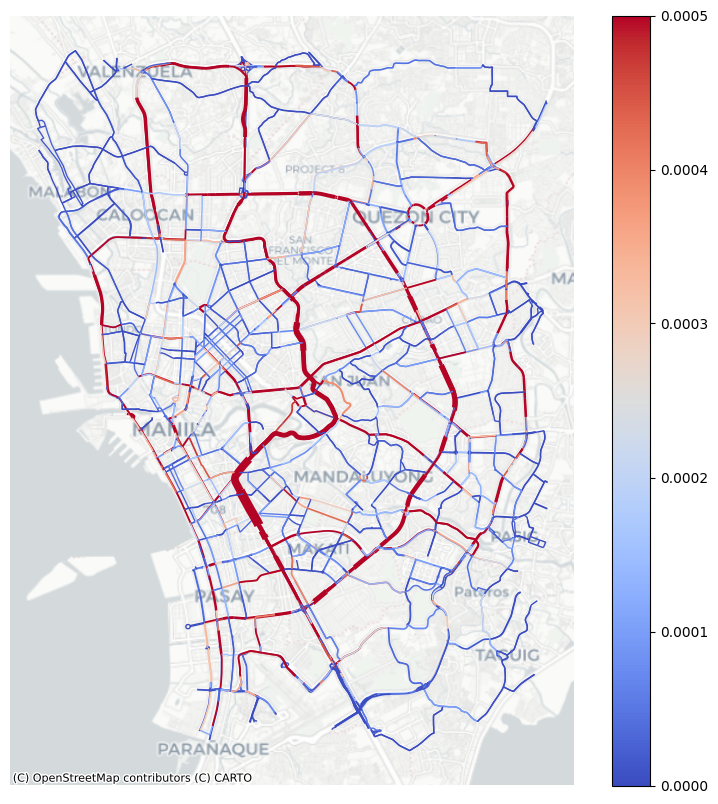

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

edge_centrality.plot(ax=ax, column='betweenness', cmap='coolwarm', legend=True, vmax = 0.05, linewidth=1+edge_centrality['betweenness'] * 50)
cx.add_basemap(ax, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

fig, ax = plt.subplots(figsize=(10, 10))

edge_centrality.plot(ax=ax, column='Traffic_betweenness', cmap='coolwarm', legend=True, vmax = 0.0005, linewidth=1+edge_centrality['Traffic_betweenness'] * 500)
cx.add_basemap(ax, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

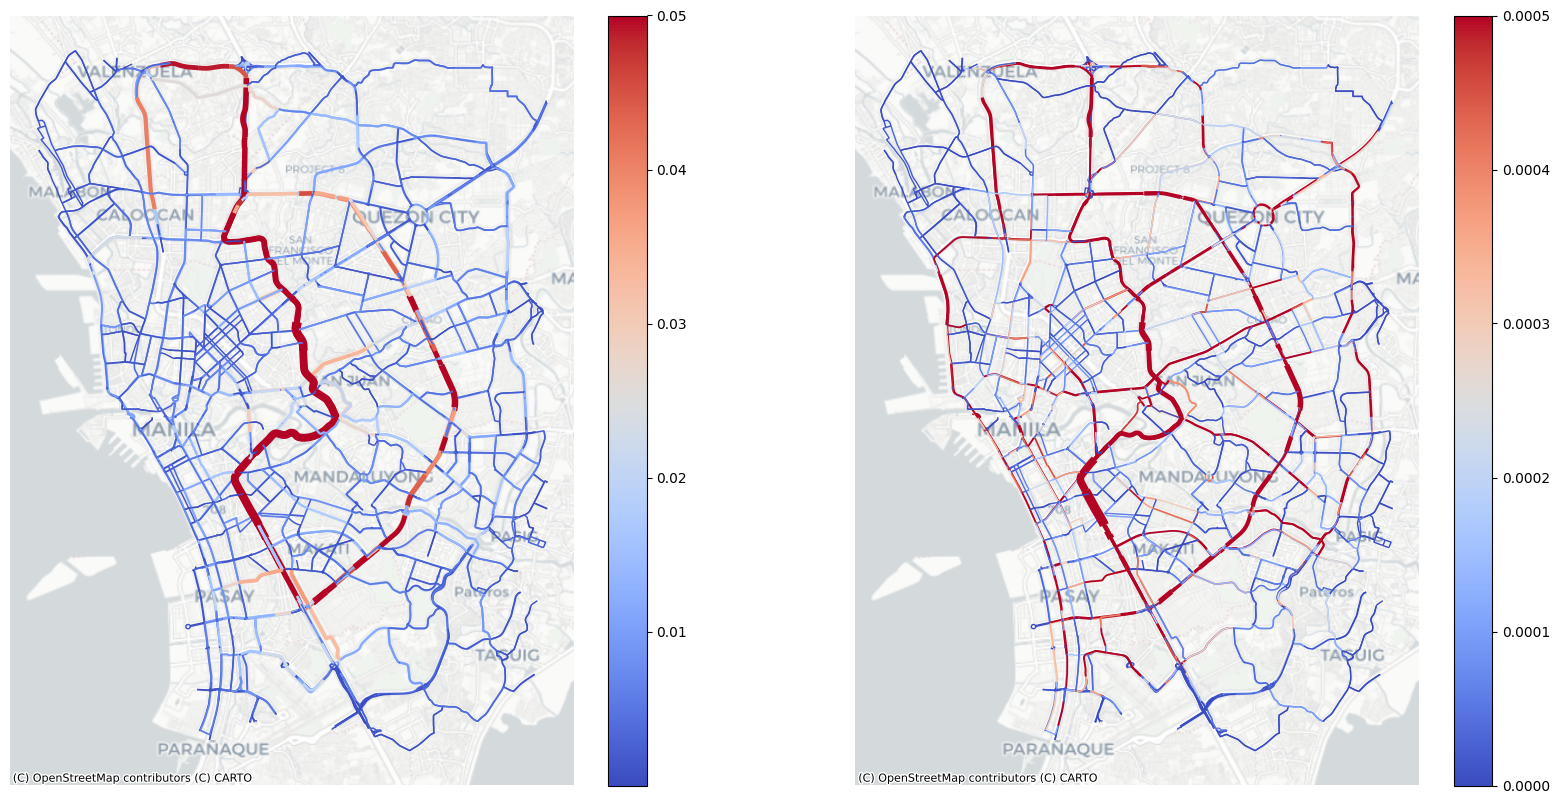

In [24]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

edge_centrality.plot(ax=ax1, column='betweenness', cmap='coolwarm', legend=True, vmax=0.05, linewidth=1+edge_centrality['betweenness'] * 50)
cx.add_basemap(ax1, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom=12)
ax1.axis('off')

edge_centrality.plot(ax=ax2, column='Traffic_betweenness', cmap='coolwarm', legend=True, vmax=0.0005, linewidth=1+edge_centrality['Traffic_betweenness'] * 500)
cx.add_basemap(ax2, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom=12)
ax2.axis('off')

plt.show()

## Zone accessibility

In [25]:
# OD congestion index
ODCI = {od: EODTT[od]/FFODTT[od] for od in ODdemand if od in EODTT}
# Zone congestion index as origin
ZoneOCI = {zone: [ODCI[od] for od in ODdemand if od in ODCI and od[0] == zone] for zone in list(zone2cent.keys())}
# average zoneOCI
ZoneOCI = {zone: sum(ZoneOCI[zone])/len(ZoneOCI[zone]) for zone in list(zone2cent.keys())}
# Zone congestion index as destination
ZoneDCI = {zone: [ODCI[od] for od in ODdemand if od in ODCI and od[1] == zone] for zone in list(zone2cent.keys())}
# average zoneDCI
ZoneDCI = {zone: sum(ZoneDCI[zone])/len(ZoneDCI[zone]) for zone in list(zone2cent.keys())}

## Emissions analysis

In [26]:
def calculate_emissions(x):
    b0 = 7.613
    b1 = -0.138565
    b2 = 0.0039151
    b3 = -0.000049519
    b4 = 0.0000002386

    x['cost'] = x['cost']*60  # seconds
    x['Speed'] = x['length']/x['cost']    # m/s
    x['Speed'] = x['Speed']*2.23694       # miles/hr
    if x['Speed'] > 100: x['Speed'] = 100
    
    CO2 = math.exp(b0+b1*x['Speed']+b2*x['Speed']**2+b3*x['Speed']**3+b4*x['Speed']**4)

    x['length'] = x['length']*0.000621371 # miles
    CO2 = CO2*x['length']*x['flow']
    CO2 = CO2/1000   # kg
    #x['Speed'] = x['Speed'].apply(lambda x: x/2.23694)  # m/s
    #x['length'] = x['length'].apply(lambda x: x/0.000621371) #  meters
    return CO2

In [27]:
edge_emissions = pd.DataFrame(columns=['from', 'to', 'emissions'])
for u,v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u,v)]['emissions'] = calculate_emissions(data.copy())
    #edge_emissions = edge_emissions.append({'from':u, 'to':v, 'emissions':G.edges[(u,v)]['emissions']}, ignore_index=True)
    edge_emissions = pd.concat([edge_emissions, pd.DataFrame.from_records([{'from':u,'to':v, 'emissions': data['emissions']}])])

C:\Users\Moeid\AppData\Local\Temp\ipykernel_10304\1229122251.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_emissions = pd.concat([edge_emissions, pd.DataFrame.from_records([{'from':u,'to':v, 'emissions': data['emissions']}])])


In [28]:
edges_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.shp')) # for geojson files use edges.geojson
zones_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/aggrid_polygon.shp')) # for geojson files use aggrid_polygon.geojson

if 'fishnetID' in zones_shape.columns:
    zones_shape.rename(columns={'fishnetID': 'ZoneID'}, inplace=True)

In [29]:
# add edge_emissions[emissions] column in edges on from and to
edges_shape = edges_shape.merge(edge_emissions, on=['from', 'to'], how='left')
edge_emissions = gpd.GeoDataFrame(edges_shape, geometry='geometry')


In [30]:
# emissions by zone
edge_emissions_byzone = gpd.sjoin(zones_shape, edge_emissions, how='left')[['ZoneID', 'emissions']]
zone_emissions = edge_emissions_byzone.groupby('ZoneID').sum()
zones_shape = zones_shape.merge(zone_emissions, on='ZoneID', how='left')

### Visualization example for zone emissions

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

zones_shape.plot(ax=ax, column='emissions', cmap='Reds', legend=True, alpha=0.5)
cx.add_basemap(ax, crs=zones_shape.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom = 12)
ax.axis('off')

(120.93407499999999, 121.09302500000001, 14.493435, 14.708264999999999)

## Noise analysis

In [32]:
def calculate_noise(data):
    L0 = 37.3  # Base noise level for light vehicles (can be adjusted) default 50
    k = 30   # Speed correction coefficient we can also use the standard formula
    distance = 25  # Reference distance in meters default 15

    flow = data['flow']  # Flow (vehicles per hour)
    speed = (data['length'] / (data['cost'] * 60)) * 3.6  # Convert m/s to km/h
    speed = min(speed, 100)  # Cap at 100 km/h for realistic values
    Lcar= 27.7 + 10 * np.log10(1 + (0.02 * speed)**3)
    Lhg= 23.1 + 12.5 * np.log10(speed) # speed should be for heavy goods vehicle instead
    f2= 10**(0.1 * (Lhg - Lcar)) 
    k2=2
    speedC= Lcar - L0 + 10 * np.log10((100 + (f2-1)) * k2) / (100 + 8.23 * k2)
    if flow == 0:
        return 0  # No noise if no traffic flow
   
    Noiseavg= L0 + 10 * np.log10(flow * (1 + 0.082 * 3))
    Leq= Noiseavg+speedC
    #Leq = L0 + 10 * np.log10(flow) + k * np.log10(speed) - 20 * np.log10(distance / 15)
    #print(data['length'], data['cost'],speed,flow,Leq)
    return Leq

In [33]:
edge_noise = pd.DataFrame(columns=['from', 'to', 'noise'])
for u, v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u, v)]['noise'] = calculate_noise(data.copy())
    edge_noise = pd.concat([edge_noise, pd.DataFrame.from_records([{'from': u, 'to': v, 'noise': Assigned_graph.edges[(u, v)]['noise']}])])

C:\Users\Moeid\AppData\Local\Temp\ipykernel_10304\2052158622.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_noise = pd.concat([edge_noise, pd.DataFrame.from_records([{'from': u, 'to': v, 'noise': Assigned_graph.edges[(u, v)]['noise']}])])


In [34]:
edges_shape = edges_shape.merge(edge_noise, on=['from', 'to'], how='left')
edge_noise = gpd.GeoDataFrame(edges_shape, geometry='geometry')

(120.93401844499999, 121.09302245500001, 14.49036297, 14.70779403)

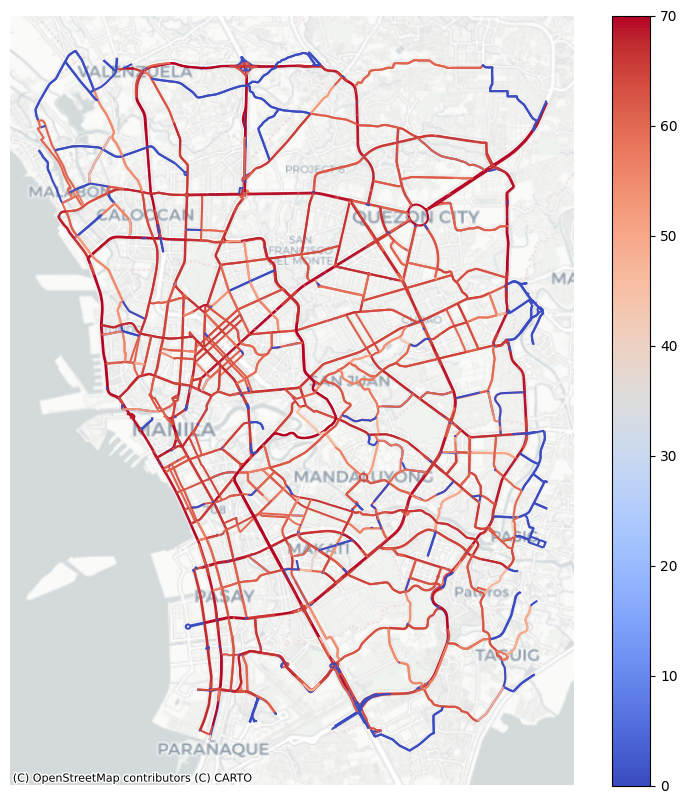

In [35]:
# cell to remove

fig, ax = plt.subplots(figsize=(10, 10))
#edge_noise = edge_noise[edge_noise['noise'] > 60]

edge_noise.plot(ax=ax, column='noise', cmap='coolwarm', legend=True, vmin = 0, vmax = 70)#, linewidth=1+edge_centrality['betweenness'] * 50)
cx.add_basemap(ax, crs=edge_noise.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

## Equity analysis

In [36]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

### Equity in accessibility

In [37]:
giniOCI = gini(np.array(list(ZoneOCI.values())))
giniDCI = gini(np.array(list(ZoneDCI.values())))

print(f"gini_Origin_CI {giniOCI} \ngini_Destination_CI {giniDCI}")

gini_Origin_CI 0.04406018339181945 
gini_Destination_CI 0.04833587203501006


### Equity in emission exposure

In [38]:
gini_em = gini(zone_emissions['emissions'])

print(f"gini_zone_emissions {gini_em} ")

gini_zone_emissions 0.3726777188449483 


# Scenraio analysis

In [39]:
# Base case assignment
Base_graph = NetGraph.copy()

accuracy, maxiter = 0.1, 15

Base_graph, TSTT, SPEdges, EODTT = Assignment(Base_graph, zone2cent, ODdemand, accuracy, maxiter)

In [40]:
remove_edges = [(31909099, 1350209200),
                (8301369364, 1482229155)             
                ]

In [41]:
for link in remove_edges:
    Scenario_graph = NetGraph.copy()
    Scenario_graph.remove_edge(link[0], link[1])

    accuracy, maxiter = 0.1, 15
    Scenario_graph, TSTT_scenario, SPEdges, EODTT = Assignment(Scenario_graph, zone2cent, ODdemand, accuracy, maxiter)
    print(f"Base case has a TSTT of {TSTT}")
    print(f"Scenario removing {link} has a TSTT of {TSTT_scenario}")
    print(f"Scenario removing {link} has a efficiency reduction of {((TSTT_scenario-TSTT)/TSTT)*100}")

Base case has a TSTT of 4231187.019588866
Scenario removing (31909099, 1350209200) has a TSTT of 4229269.474025165
Scenario removing (31909099, 1350209200) has a efficiency reduction of -0.04531932894537626
Base case has a TSTT of 4231187.019588866
Scenario removing (8301369364, 1482229155) has a TSTT of 4237981.580085865
Scenario removing (8301369364, 1482229155) has a efficiency reduction of 0.1605828450867946
